In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Attention:
Ce notebook a été développé par des étudiants universitaires de PolyFinances et n'émane pas des conférenciers de la CDPQ. Nous ne pouvons garantir son absence totale d'erreurs. Il est mis à votre disposition comme un outil pour vous aider dans l'élaboration de vos solutions et pour vous montrer les notions théoriques issues du domaine de la finance pouvant être utilisées

*Auteur : Fedwin Chatelier*

# Modèle à facteurs (Fama-French)

Nous allons maintenant explorer un modèle d'évaluation des actifs connu sous le nom de méthode Fama-French. Cette méthode est largement utilisée pour analyser la performance d'un portefeuille d'investissements en prenant en compte plusieurs facteurs de risque, au-delà du simple rendement global du marché. Les trois principaux facteurs étudiés sont la prime de risque liée au marché (Mkt-RF), la prime de taille (SMB, basée sur la capitalisation boursière), et la prime de valeur (HML, basée sur la valorisation des actifs). En comprenant comment ces facteurs influencent les rendements des actifs, les investisseurs peuvent prendre des décisions plus éclairées pour gérer leur portefeuille et évaluer la performance de leurs investissements.

- Papier original (PDF): https://www.bauer.uh.edu/rsusmel/phd/Fama-French_JFE93.pdf
- Résumé investopedia: https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp 

![image.png](https://miro.medium.com/v2/resize:fit:1400/1*FTzi_FxeJhLxTf41Px6WxQ.png)


Les données utilisées par la librairie "getFamaFrenchFactors" peuvent être directement récupérées à l'addresse suivante : https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [7]:
%%capture 
pip install getFamaFrenchFactors bs4 html5lib lxml

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import getFamaFrenchFactors as gff

ff3 = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3.index = pd.to_datetime(ff3.date_ff_factors)
ff3 = ff3.iloc[:, 1:]
ff3

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1926-08-31,0.0264,-0.0117,0.0382,0.0025
1926-09-30,0.0036,-0.0140,0.0013,0.0023
1926-10-31,-0.0324,-0.0009,0.0070,0.0032
1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...
2023-04-30,0.0061,-0.0335,-0.0004,0.0035
2023-05-31,0.0035,0.0161,-0.0772,0.0036
2023-06-30,0.0646,0.0154,-0.0026,0.0040


## Loading data

In [9]:
ROOT='../kaggle/input/dt23-test/' # remove the dot (.) for the kaggle version

In [10]:
adjusted_close = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close.index = pd.to_datetime(adjusted_close.index)
adjusted_close = adjusted_close.dropna(axis=1).iloc[:, :20]

adjusted_close.shape

(6022, 20)

In [11]:
start_FF,stop_FF = pd.to_datetime('2020-12-31'),pd.to_datetime('2023-09-01')
monthly_data = adjusted_close.resample('M').mean()
monthly_adjusted_close = monthly_data[(monthly_data.index>=pd.to_datetime(start_FF))&(monthly_data.index<=pd.to_datetime(stop_FF))]
#month_FF= pd.to_datetime('2023-08-31')
years_2021_2023_FF3 = ff3[(ff3.index>pd.to_datetime(start_FF))&(ff3.index<=pd.to_datetime(stop_FF))]
years_2021_2023_FF3

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
2021-01-31,-0.0003,0.0736,0.0301,0.0001
2021-02-28,0.0278,0.0205,0.0715,0.0000
2021-03-31,0.0308,-0.0237,0.0739,0.0000
2021-04-30,0.0493,-0.0319,-0.0095,0.0000
2021-05-31,0.0029,-0.0025,0.0709,0.0000
2021-06-30,0.0275,0.0168,-0.0787,0.0000
2021-07-31,0.0127,-0.0397,-0.0178,0.0000
2021-08-31,0.0291,-0.0042,-0.0015,0.0000
2021-09-30,-0.0437,0.0071,0.0508,0.0000


## Graphe du rendement de CSCO comparé aux 3 facteurs

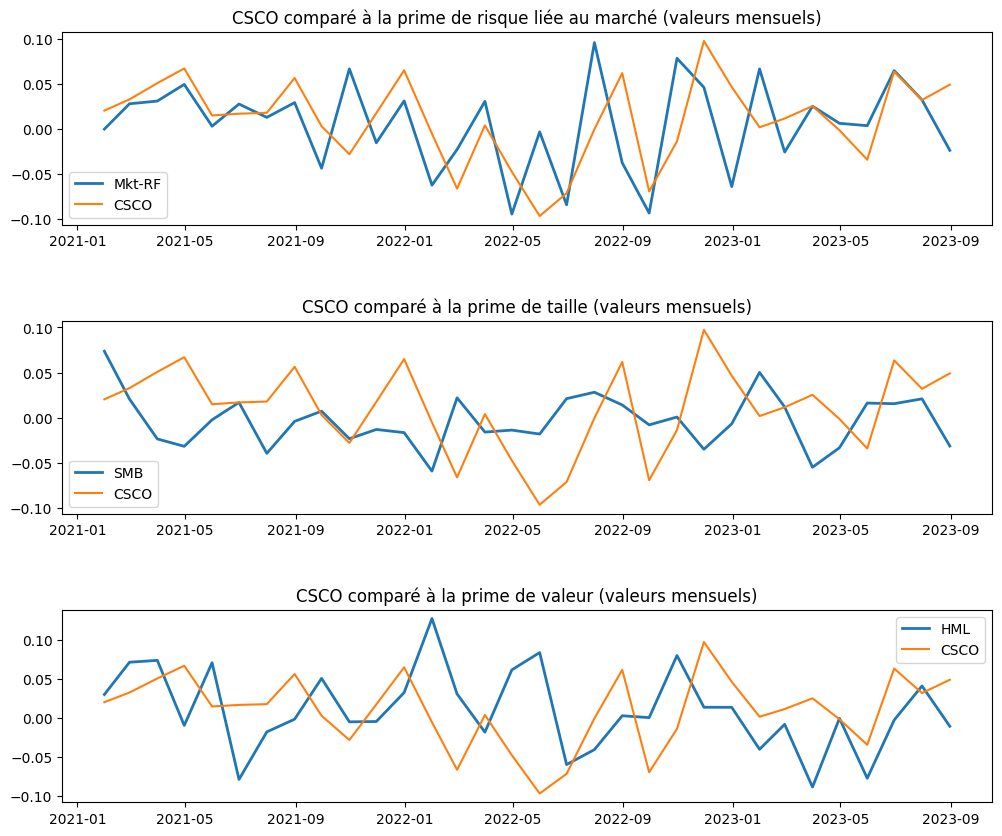

In [12]:
csco = monthly_adjusted_close.iloc[:, :1]
csco_ret = csco.pct_change().dropna()

fig, axis = plt.subplots(3, 1,figsize=(12, 10))
axis[0].plot(years_2021_2023_FF3['Mkt-RF'],linewidth=2, label='Mkt-RF')
axis[0].plot(csco_ret, label="CSCO")
axis[0].set_title('CSCO comparé à la prime de risque liée au marché (valeurs mensuels)')
axis[0].legend()

axis[1].plot(years_2021_2023_FF3['SMB'],linewidth=2, label='SMB')
axis[1].plot(csco_ret, label="CSCO")
axis[1].set_title('CSCO comparé à la prime de taille (valeurs mensuels)')
axis[1].legend()

axis[2].plot(years_2021_2023_FF3['HML'],linewidth=2, label='HML')
axis[2].plot(csco_ret, label="CSCO")
axis[2].set_title('CSCO comparé à la prime de valeur (valeurs mensuels)')
axis[2].legend()

plt.subplots_adjust(hspace=0.5)


## Trouvons les valeurs des betas

In [13]:
import statsmodels.api as sm

def osl_model(y, x):
    # Estime les bêtas par régression
    model = sm.OLS(y, sm.tools.add_constant(x))
    result = model.fit()
    print(result.summary())
    return result

In [14]:
y = csco_ret["adjusted_close_CSCO"] - years_2021_2023_FF3["RF"]
x = years_2021_2023_FF3[["Mkt-RF", "SMB", "HML"]]

res = osl_model(y, x)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     2.115
Date:                Sat, 04 Nov 2023   Prob (F-statistic):              0.121
Time:                        00:44:18   Log-Likelihood:                 57.083
No. Observations:                  32   AIC:                            -106.2
Df Residuals:                      28   BIC:                            -100.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.008      0.709      0.4

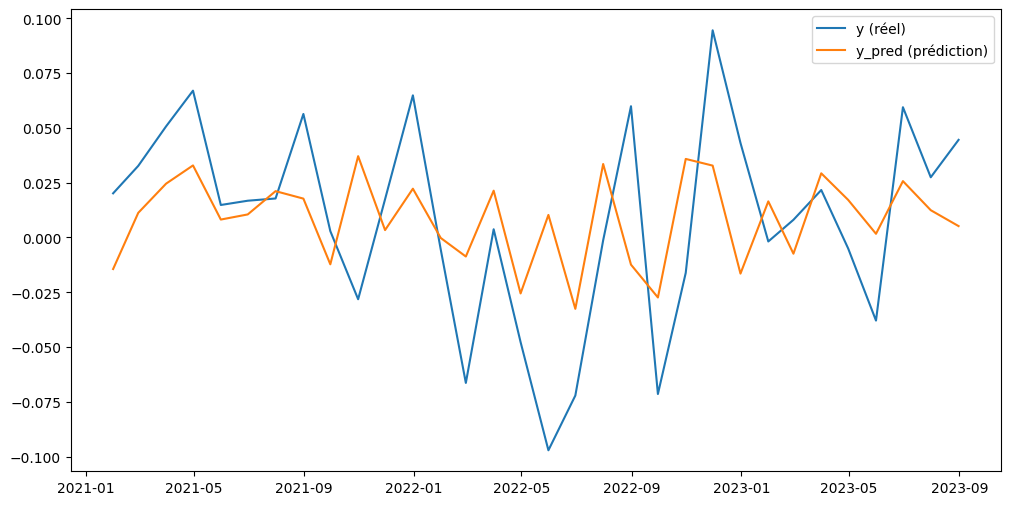

In [15]:
coefficients = res.params

y_pred = coefficients["const"] + coefficients["Mkt-RF"] * x["Mkt-RF"] + coefficients["SMB"] * x["SMB"] + coefficients["HML"] * x["HML"]

plt.subplots(1, 1, figsize=(12, 6))
plt.plot(y, label="y (réel)")
plt.plot(y_pred, label="y_pred (prédiction)")

plt.legend()
plt.show()


## Calcul du rendement probable de CSCO

In [16]:
average_FF3 = years_2021_2023_FF3.apply(np.mean)

alpha, ß1, ß2, ß3 = res.params

exp_returns = ß1*average_FF3['Mkt-RF'] + ß2*average_FF3['SMB'] + ß3*average_FF3['HML'] + alpha

Ra = average_FF3['RF'] + exp_returns

In [17]:
print(f'Le rendement mensuel probable attendus pour CSCO est de :',Ra)
print(f'Le rendement annuel probable attendus pour CSCO est de:',((1 + Ra) ** 12) - 1) 

Le rendement mensuel probable attendus pour CSCO est de : 0.009953246084321651
Le rendement annuel probable attendus pour CSCO est de: 0.12619924710698083
